<a href="https://colab.research.google.com/github/Bhoj8888/Portflio-Optimization/blob/main/Updated_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter stock tickers separated by commas: AAPL, BNNNN, KO


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BNNNN']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed


The ticker(s) BNNNN you entered is not available for analysis. Please enter the appropriate ticker(s).
Enter stock tickers separated by commas: AAPL, KO, AMZN


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


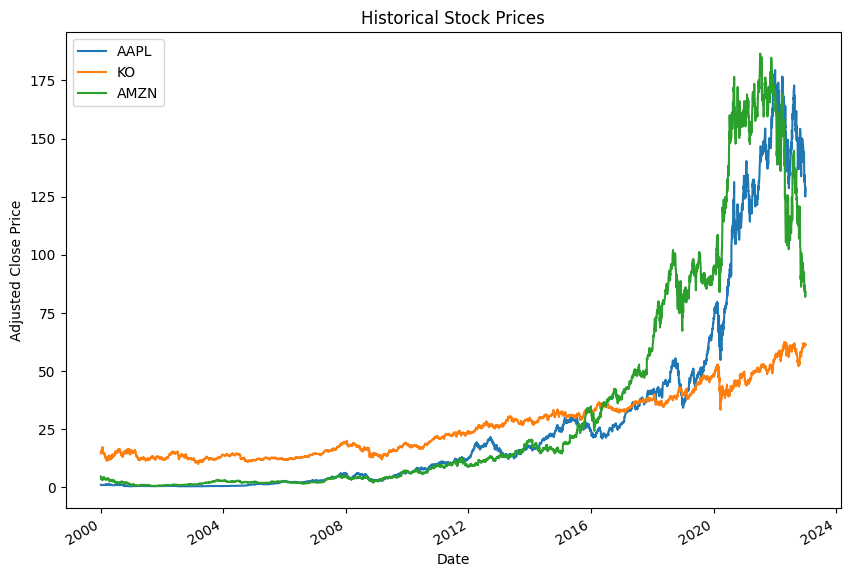

              AAPL           KO         AMZN
count  5786.000000  5786.000000  5786.000000
mean      0.001198     0.000337     0.001008
std       0.025124     0.013223     0.031910
min      -0.518692    -0.100610    -0.247661
25%      -0.010370    -0.005482    -0.012139
50%       0.000869     0.000445     0.000407
75%       0.013140     0.006385     0.013604
max       0.139049     0.138796     0.344714


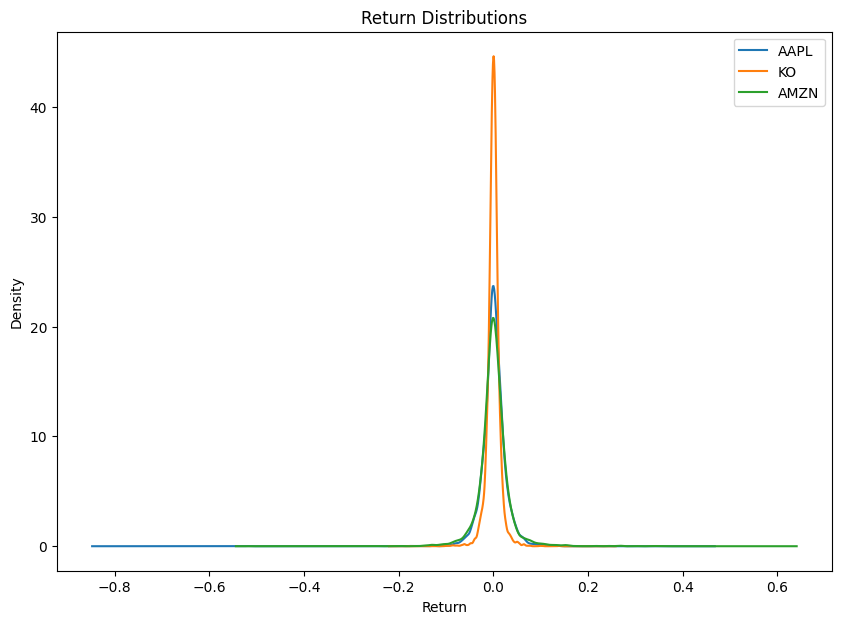

          AAPL        KO      AMZN
AAPL  1.000000  0.235887  0.370883
KO    0.235887  1.000000  0.165175
AMZN  0.370883  0.165175  1.000000


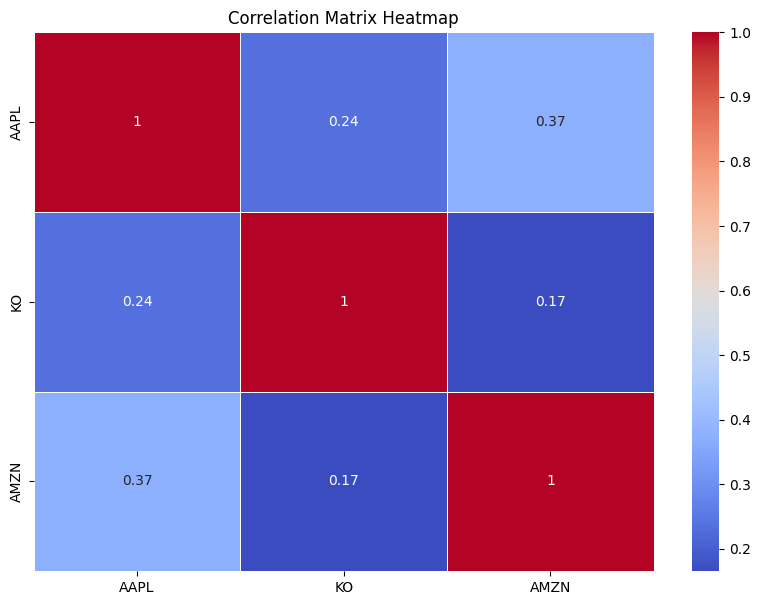

Historical Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 0.2301691790297212
Annualized Standard Deviation: 0.280481602760413
Sharpe Ratio: 0.7849683432456331
Weights: [0.5432465  0.29496869 0.16178481]

Historical Minimum Volatility Portfolio Allocation

Annualized Return: 0.12150381471560252
Annualized Standard Deviation: 0.1988282416117644
Sharpe Ratio: 0.5608047117035159
Weights: [0.11901155 0.8174576  0.06353085]
Epoch 1/5
4628/4628 [==============================] - 26s 5ms/step - loss: 6.1168e-04
Epoch 2/5
4628/4628 [==============================] - 25s 5ms/step - loss: 6.0354e-04
Epoch 3/5
4628/4628 [==============================] - 22s 5ms/step - loss: 6.0279e-04
Epoch 4/5
4628/4628 [==============================] - 24s 5ms/step - loss: 6.0316e-04
Epoch 5/5
37/37 [==============================] - 1s 3ms/step
Best model: Linear Regression
RMSE Scores: {'Linear Regression': 0.02603147897900257, 'Random Forest': 0.02748588393093054, 'LSTM': 0.02611595382171002}

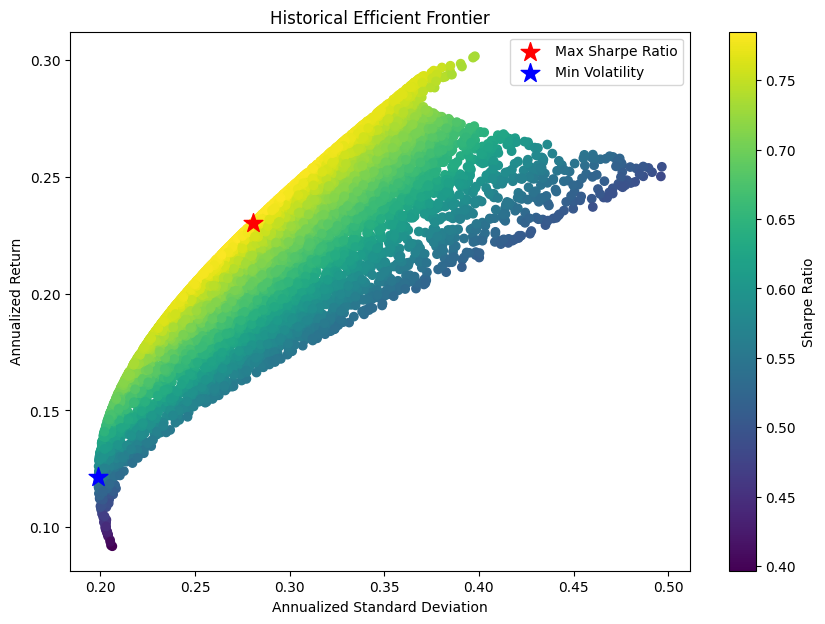

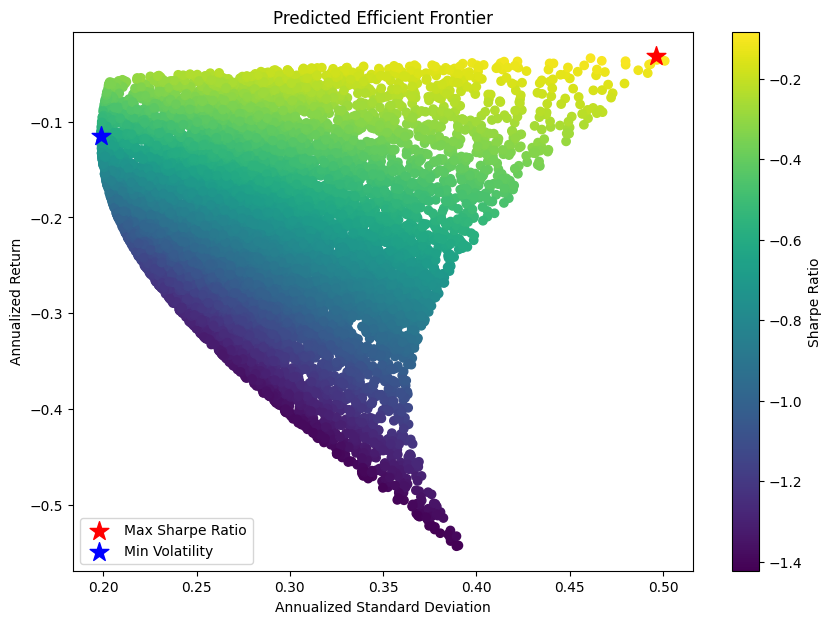

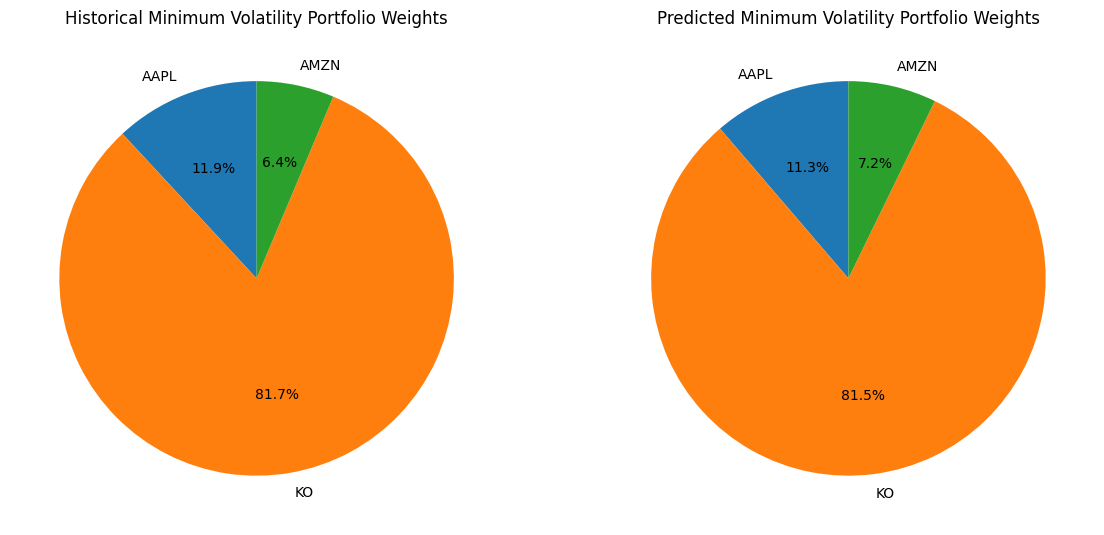

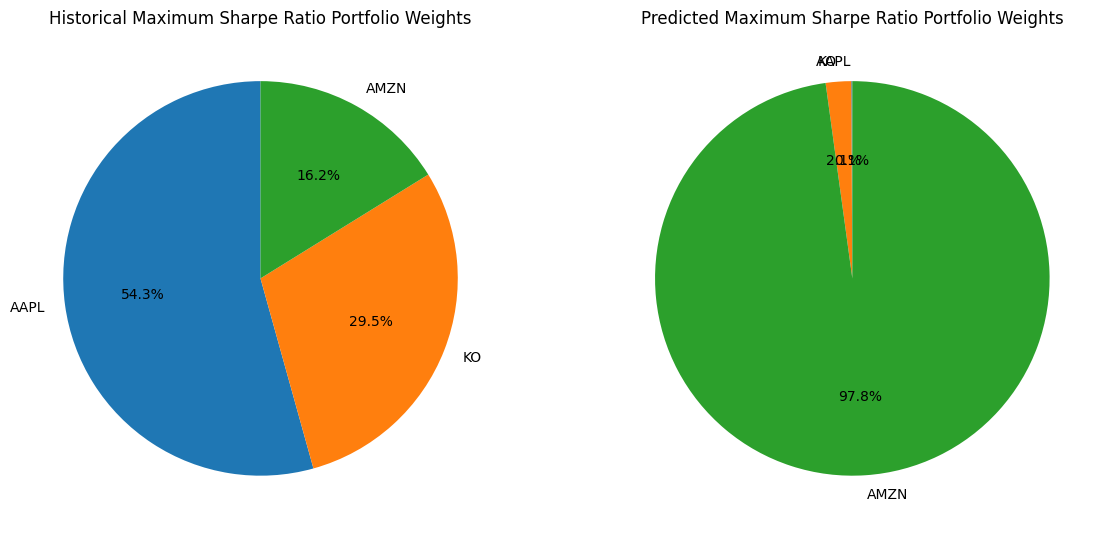

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

# Function to fetch data from Yahoo Finance
def fetch_data(tickers, start, end):
    all_data = pd.DataFrame()
    invalid_tickers = []

    for ticker in tickers:
        try:
            data = yf.download(ticker, start=start, end=end)
            if data.empty:
                invalid_tickers.append(ticker)
            else:
                all_data[ticker] = data['Adj Close']
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            invalid_tickers.append(ticker)

    return all_data, invalid_tickers

# Function to train and evaluate models
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'LSTM': Sequential([
            LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
            LSTM(50, return_sequences=False),
            Dense(25),
            Dense(y_train.shape[1])
        ])
    }

    rmse_scores = {}

    # Linear Regression and Random Forest
    for name, model in models.items():
        if name != 'LSTM':
            model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
            y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            rmse_scores[name] = rmse

    # LSTM Model
    X_train_lstm = X_train
    X_test_lstm = X_test
    models['LSTM'].compile(optimizer='adam', loss='mean_squared_error')
    models['LSTM'].fit(X_train_lstm, y_train, epochs=5, batch_size=1, verbose=1)
    y_pred_lstm = models['LSTM'].predict(X_test_lstm)
    rmse_scores['LSTM'] = np.sqrt(mean_squared_error(y_test, y_pred_lstm))

    best_model_name = min(rmse_scores, key=rmse_scores.get)
    best_model = models[best_model_name]

    return best_model, best_model_name, rmse_scores

# Function to simulate portfolios and calculate metrics
def simulate_portfolios(mean_returns, cov_matrix, num_portfolios=10000, risk_free_rate=0.01):
    results = np.zeros((3, num_portfolios))
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)

        portfolio_return = np.sum(weights * mean_returns) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev

        results[0, i] = portfolio_return
        results[1, i] = portfolio_std_dev
        results[2, i] = sharpe_ratio
        weights_record.append(weights)

    return results, weights_record

# Main Function
def main():
    while True:
        # User input for stock tickers
        tickers = input("Enter stock tickers separated by commas: ").split(',')
        tickers = [ticker.strip() for ticker in tickers]

        # Fetch historical stock price data
        data, unavailable_tickers = fetch_data(tickers, start="2000-01-01", end="2023-01-01")

        if unavailable_tickers:
            print(f"The ticker(s) {', '.join(unavailable_tickers)} you entered is not available for analysis. Please enter the appropriate ticker(s).")
            continue
        elif data is None or data.empty:
            print("No data fetched for the given tickers. Please enter the appropriate ticker(s).")
            continue
        else:
            break

    # Plot historical stock prices
    data.plot(figsize=(10, 7))
    plt.title('Historical Stock Prices')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.show()

    # Calculate daily returns
    returns = data.pct_change().dropna()

    if returns.empty:
        print("No returns data available. Please enter valid tickers.")
        return

    # Summary statistics
    summary_stats = returns.describe()
    print(summary_stats)

    # Plot return distributions
    returns.plot(kind='density', figsize=(10, 7))
    plt.title('Return Distributions')
    plt.xlabel('Return')
    plt.show()

    # Correlation matrix
    correlation_matrix = returns.corr()
    print(correlation_matrix)

    # Generate a heatmap of the correlation matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix Heatmap')
    plt.show()

    # Number of portfolios to simulate
    num_portfolios = 10000

    # Initialize arrays to store simulation results
    results = np.zeros((3, num_portfolios))
    weights_record = []

    # Extract the mean returns and the covariance matrix of the returns
    mean_returns = returns.mean()
    cov_matrix = returns.cov()

    # Risk-free rate for Sharpe ratio calculation (e.g., 1% annual risk-free rate)
    risk_free_rate = 0.01

    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)

        portfolio_return = np.sum(weights * mean_returns) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev

        results[0, i] = portfolio_return
        results[1, i] = portfolio_std_dev
        results[2, i] = sharpe_ratio
        weights_record.append(weights)

    # Convert results array to Pandas DataFrame
    results_frame = pd.DataFrame(results.T, columns=['Return', 'Standard Deviation', 'Sharpe Ratio'])

    # Locate the portfolio with the maximum Sharpe ratio
    max_sharpe_idx = results_frame['Sharpe Ratio'].idxmax()
    max_sharpe_port = results_frame.iloc[max_sharpe_idx]
    max_sharpe_weights = weights_record[max_sharpe_idx]

    # Locate the portfolio with the minimum standard deviation
    min_vol_idx = results_frame['Standard Deviation'].idxmin()
    min_vol_port = results_frame.iloc[min_vol_idx]
    min_vol_weights = weights_record[min_vol_idx]

    print("Historical Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualized Return:", max_sharpe_port[0])
    print("Annualized Standard Deviation:", max_sharpe_port[1])
    print("Sharpe Ratio:", max_sharpe_port[2])
    print("Weights:", max_sharpe_weights)

    print("\nHistorical Minimum Volatility Portfolio Allocation\n")
    print("Annualized Return:", min_vol_port[0])
    print("Annualized Standard Deviation:", min_vol_port[1])
    print("Sharpe Ratio:", min_vol_port[2])
    print("Weights:", min_vol_weights)

    # Prepare data for forecasting
    X = returns[:-1].values
    y = returns.shift(-1).dropna().values

    # Reshape X and y for LSTM
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = y.reshape(y.shape[0], y.shape[1])

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train and evaluate models
    best_model, best_model_name, rmse_scores = train_and_evaluate_models(X_train, X_test, y_train, y_test)
    print(f"Best model: {best_model_name}")
    print(f"RMSE Scores: {rmse_scores}")

    # Make predictions using the best model
    if best_model_name == 'LSTM':
        predicted_returns = pd.Series(best_model.predict(X_test)[-1], index=tickers)
    else:
        predicted_returns = pd.Series(best_model.predict(X_test.reshape(X_test.shape[0], -1))[-1], index=tickers)

    # Simulate portfolios based on predicted returns
    mean_returns_pred = predicted_returns  # Use predicted returns directly
    cov_matrix_pred = returns.cov()
    results_pred, weights_record_pred = simulate_portfolios(mean_returns_pred, cov_matrix_pred)

    # Convert results array to Pandas DataFrame
    results_frame_pred = pd.DataFrame(results_pred.T, columns=['Return', 'Standard Deviation', 'Sharpe Ratio'])

    # Locate the portfolio with the maximum Sharpe ratio
    max_sharpe_idx_pred = results_frame_pred['Sharpe Ratio'].idxmax()
    max_sharpe_port_pred = results_frame_pred.iloc[max_sharpe_idx_pred]
    max_sharpe_weights_pred = weights_record_pred[max_sharpe_idx_pred]

    # Locate the portfolio with the minimum standard deviation
    min_vol_idx_pred = results_frame_pred['Standard Deviation'].idxmin()
    min_vol_port_pred = results_frame_pred.iloc[min_vol_idx_pred]
    min_vol_weights_pred = weights_record_pred[min_vol_idx_pred]

    print("\nPredicted Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualized Return:", max_sharpe_port_pred[0])
    print("Annualized Standard Deviation:", max_sharpe_port_pred[1])
    print("Sharpe Ratio:", max_sharpe_port_pred[2])
    print("Weights:", max_sharpe_weights_pred)

    print("\nPredicted Minimum Volatility Portfolio Allocation\n")
    print("Annualized Return:", min_vol_port_pred[0])
    print("Annualized Standard Deviation:", min_vol_port_pred[1])
    print("Sharpe Ratio:", min_vol_port_pred[2])
    print("Weights:", min_vol_weights_pred)

    # Display weights for historical and predicted minimum volatility portfolio
    min_vol_weights_df = pd.DataFrame({
        'Historical': min_vol_weights,
        'Predicted': min_vol_weights_pred
    }, index=tickers)
    print("\nWeights for Minimum Volatility Portfolio:\n")
    print(min_vol_weights_df)

    # Display weights for historical and predicted maximum Sharpe ratio portfolio
    max_sharpe_weights_df = pd.DataFrame({
        'Historical': max_sharpe_weights,
        'Predicted': max_sharpe_weights_pred
    }, index=tickers)
    print("\nWeights for Maximum Sharpe Ratio Portfolio:\n")
    print(max_sharpe_weights_df)

    # Plot the historical efficient frontier
    plt.figure(figsize=(10, 7))
    plt.scatter(results_frame['Standard Deviation'], results_frame['Return'], c=results_frame['Sharpe Ratio'], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(max_sharpe_port[1], max_sharpe_port[0], color='r', marker='*', s=200, label='Max Sharpe Ratio')
    plt.scatter(min_vol_port[1], min_vol_port[0], color='b', marker='*', s=200, label='Min Volatility')
    plt.title('Historical Efficient Frontier')
    plt.xlabel('Annualized Standard Deviation')
    plt.ylabel('Annualized Return')
    plt.legend()
    plt.show()

    # Plot the predicted efficient frontier
    plt.figure(figsize=(10, 7))
    plt.scatter(results_frame_pred['Standard Deviation'], results_frame_pred['Return'], c=results_frame_pred['Sharpe Ratio'], cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(max_sharpe_port_pred[1], max_sharpe_port_pred[0], color='r', marker='*', s=200, label='Max Sharpe Ratio')
    plt.scatter(min_vol_port_pred[1], min_vol_port_pred[0], color='b', marker='*', s=200, label='Min Volatility')
    plt.title('Predicted Efficient Frontier')
    plt.xlabel('Annualized Standard Deviation')
    plt.ylabel('Annualized Return')
    plt.legend()
    plt.show()

    # Plot the weights of the historical and predicted minimum volatility portfolio as pie charts
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    min_vol_weights_df['Historical'].plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axs[0], legend=False)
    axs[0].set_title('Historical Minimum Volatility Portfolio Weights')
    axs[0].set_ylabel('')
    min_vol_weights_df['Predicted'].plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axs[1], legend=False)
    axs[1].set_title('Predicted Minimum Volatility Portfolio Weights')
    axs[1].set_ylabel('')
    plt.show()

    # Plot the weights of the historical and predicted maximum Sharpe ratio portfolio as pie charts
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    max_sharpe_weights_df['Historical'].plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axs[0], legend=False)
    axs[0].set_title('Historical Maximum Sharpe Ratio Portfolio Weights')
    axs[0].set_ylabel('')
    max_sharpe_weights_df['Predicted'].plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axs[1], legend=False)
    axs[1].set_title('Predicted Maximum Sharpe Ratio Portfolio Weights')
    axs[1].set_ylabel('')
    plt.show()

# Run the main function
if __name__ == "__main__":
    main()
